# SYSID - Trabalho (ML - SISO.LM)

Alunos: 

Pedro Henrique Cardoso Paulo</br>
Felipe da Costa Pereira

Professor: Helon

## Objetivo

TBD

## Passo 0 - Importando bibliotecas

In [25]:
# Pacotes padrao
import os
import itertools
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#sisidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.narmax_tools import regressor_code

#Modelos
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

#Interface SYSID
from SYSIDPreProcessor import SYSIDRegressor

#Busca de modelos
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Scores
from sklearn.metrics import r2_score

# Disabling warnings
import warnings
from sklearn.exceptions import DataConversionWarning

#Definindo random_state
rs = 85

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [26]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_Trabalho/Volve-Dataset/data/volve_compiled.pkl


In [27]:
for wellp in data['OP'].keys():
    print(wellp)

15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


### 0.2 - Visualizando dados

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


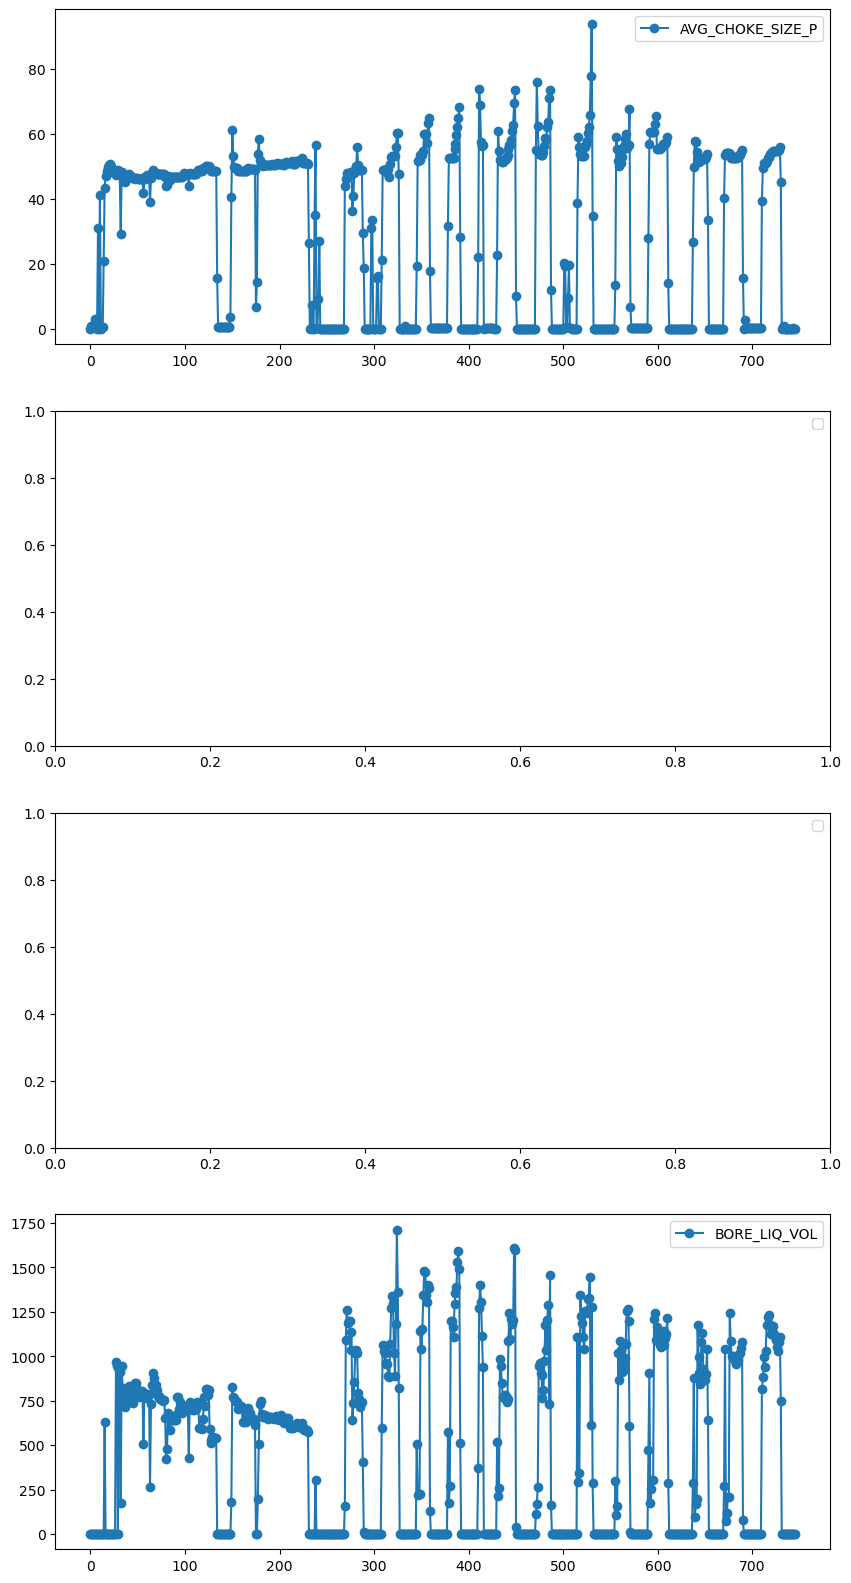

In [28]:
case = "15/9-F-1 C"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        #'AVG_DOWNHOLE_PRESSURE',
        #'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        #'AVG_WHT_P',
        #'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]

time = data_case['N']
fig, ax = plt.subplots(4,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_Q:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[2].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[3].plot(time, data_case[var], '-o', label=var)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [29]:
data_case = data_case.iloc[28:,:]
#data_case = data_case[data_case['AVG_DOWNHOLE_PRESSURE']>0]
data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [30]:
p_train = 0.7 #70% treino

### 1.2 - Separando os conjuntos

In [31]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[:,:]
y_te = y[:,:]

In [32]:
print(
    X1_tr.shape,
    X1_te.shape
)

(502, 1) (718, 1)


### 1.3 - Removendo a escala 

In [33]:
X_scale = MinMaxScaler()
y_scale = MinMaxScaler()
X_tr = X_scale.fit_transform(X1_tr)
X_te = X_scale.transform(X1_te)
y_tr = y_scale.fit_transform(y_tr)
y_te = y_scale.transform(y_te)

## Passo 2 - Declarando os modelos 

In [34]:
models = []

### 2.1 - ARMAX (sysidentpy)

In [35]:
basis_function = Polynomial(degree=1)
n = 2
na = n
nb = [n] * X1.shape[1]
ne = 1
n_terms = 6
model = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    #n_terms=n_terms,
    model_type='NARMAX',
    #extended_least_squares=True,
)

models.append(('ARMAX', model))

### 2.2 - NARMAX (sysidentpy)

In [36]:
basis_function = Polynomial(degree=2)
n = 2
na = n
nb = [n] * X1.shape[1]
ne = 1
n_terms = 6
model = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    #n_terms=n_terms,
    model_type='NARMAX',
    #extended_least_squares=True,
)
models.append(('NARMAX', model))

### 2.3 - Modelos de ML (sklearn)

#### 2.3.1 - Modelos

In [37]:
models_ml = [
    ('LinReg'          ,      LinearRegression(copy_X=True)), #ARX Equivalent
    ('PolyReg'         ,      Pipeline([('Poly', PolynomialFeatures(degree=2)), ('Reg', LinearRegression(copy_X=True))])), #NARX Equivalent
    ('SVM'             ,      SVR(max_iter=-1)),
    ('KNN'             ,      KNeighborsRegressor()),
    ('DecisionTree'    ,      DecisionTreeRegressor(random_state=rs)),
    ('RandomForest'    ,      RandomForestRegressor(random_state=rs)),
    ('GradientBoosting',      GradientBoostingRegressor(random_state=rs)),
    ('ExtraTrees'      ,      ExtraTreesRegressor(random_state=rs)),
    ('MLP'             ,      MLPRegressor(random_state=rs, )),
]

#### 2.3.2 - Parâmetros (RandomSearchCV)

In [38]:
parameters = [
    {
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'positive'                     : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'Reg__positive'                : [True, False],
        #'Poly__degree'                : [2, 3, 4, 5],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(5,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'loss'                   : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'learning_rate'          : stats.loguniform(1e-5, 1e1),
        'criterion'              : ['friedman_mse', 'squared_error'],
        'subsample'              : stats.uniform(), 
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'criterion'              : ['squared_error', 'absolute_error'],
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        'activation'            : ['relu'], #'logistic', 'tanh'],
        'early_stopping'        : [True, False],
        'alpha'                 : stats.loguniform(1e-4, 1e0),
        'hidden_layer_sizes'    : [] 
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=1)]
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=2)]
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=3)]
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=4)],
        'max_iter'              : [10000],#stats.randint(200,10000),
        'batch_size'            : [16, 32, 64, 128, 256],
        'solver'                : ['adam'], #'lbfgs'],
        'tol'                   : stats.loguniform(1e-7, 1e-1),

    },
]

In [39]:
kfolds = 5
niters = 10
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)

In [40]:
n_iter = 100 #Numero de iterações do rdmsearch 

for model, params in zip(models_ml, parameters):
    rdmsearch = RandomizedSearchCV(model[1], verbose=0, scoring='r2', 
                                   param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                   cv=rkf, random_state=rs)
    
    sidmodel = SYSIDRegressor(
        nX=6, ny=6,
        estimator=rdmsearch, 
        preprocessor=MinMaxScaler(),
        #expansor=PolynomialFeatures(degree=2)
        )
    
    models.append(
        (model[0], sidmodel)
    )


n_models = len(models)

In [41]:
results = {
    'MODEL':[],
    'ORDER':[],
    'R2 TRAIN OSA':[],
    'R2 TEST OSA':[],
    'R2 TRAIN FS':[],
    'R2 TEST FS':[],
    'MODEL OBJ':[],
    'PARS':[]
}

order_progression = {
    'MODEL':[],
    'ORDER':[],
    'R2 TRAIN OSA':[],
    'R2 TEST OSA':[],
    'R2 TRAIN FS':[],
    'R2 TEST FS':[],
    'MODEL OBJ':[],
}

#models = models[-1:]

In [42]:
for model in models:
    print(model[0])

ARMAX
NARMAX
LinReg
PolyReg
SVM
KNN
DecisionTree
RandomForest
GradientBoosting
ExtraTrees
MLP


Starting evaluation of model: ARMAX
    Trying order: 2
        R2 score OSA (Train): 0.7431025553758253
        R2 score OSA (Test): 0.7479534171611602
        R2 score FS (Train): -1.1944614825452442
        R2 score FS (Test): -0.9904526966175282
    Trying order: 3
        R2 score OSA (Train): 0.7514369682921085
        R2 score OSA (Test): 0.7533807437144748
        R2 score FS (Train): -1.0989273506708086
        R2 score FS (Test): -0.9282415730830547
    Trying order: 4
        R2 score OSA (Train): 0.7514993667109067
        R2 score OSA (Test): 0.7534213727244465
        R2 score FS (Train): -1.0943678249789142
        R2 score FS (Test): -0.9252724435111244
    Trying order: 5
        R2 score OSA (Train): 0.7555860831510304
        R2 score OSA (Test): 0.756082613226926
        R2 score FS (Train): -1.154135738874475
        R2 score FS (Test): -0.964192869141218
    Trying order: 6
        R2 score OSA (Train): 0.7615911604268613
        R2 score OSA (Test): 0.75999307460

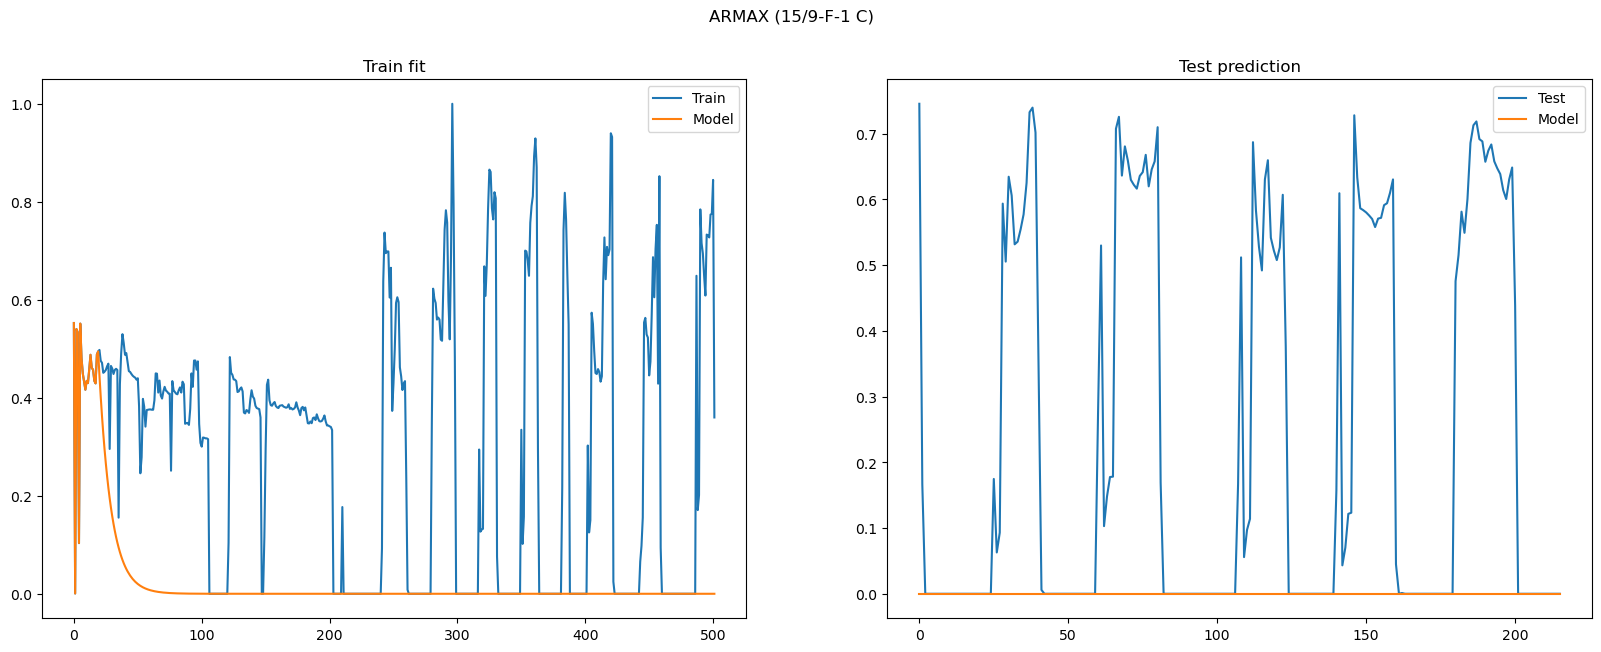

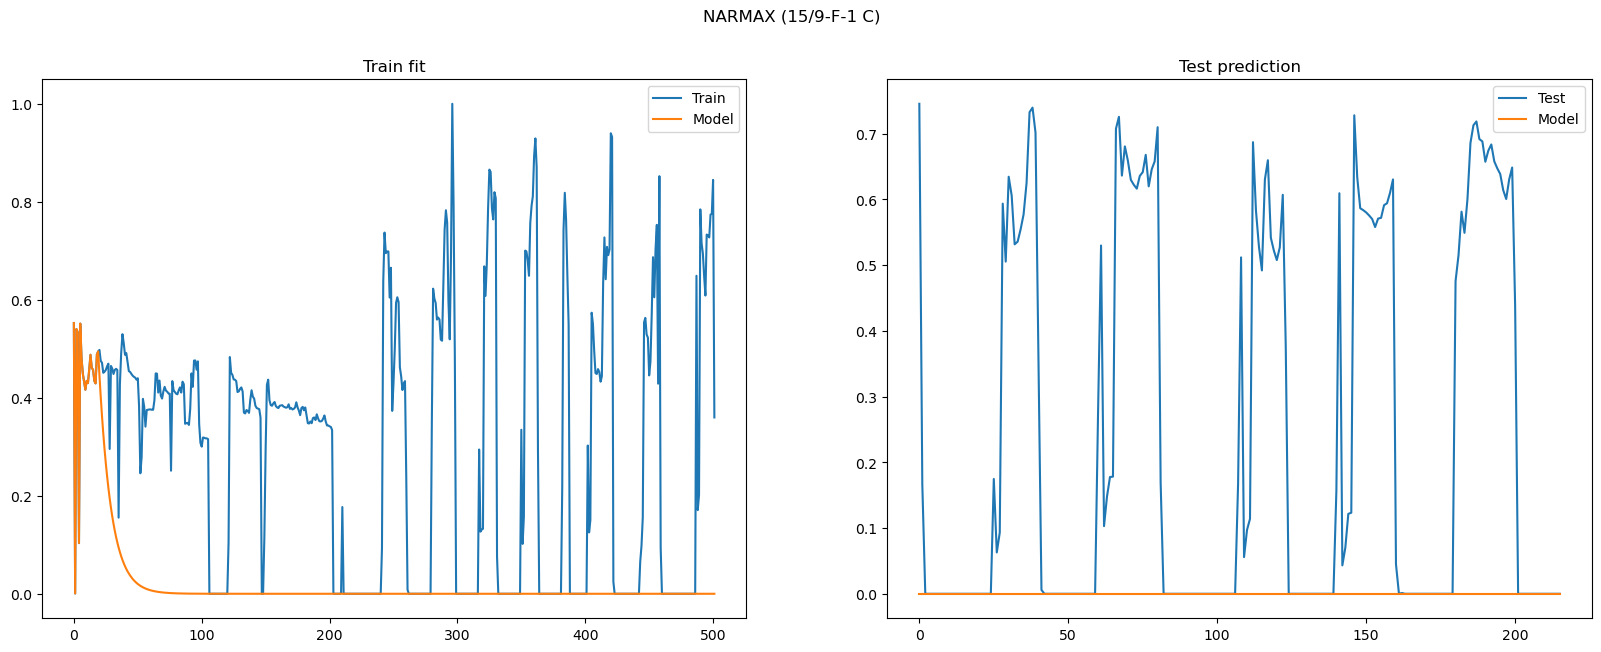

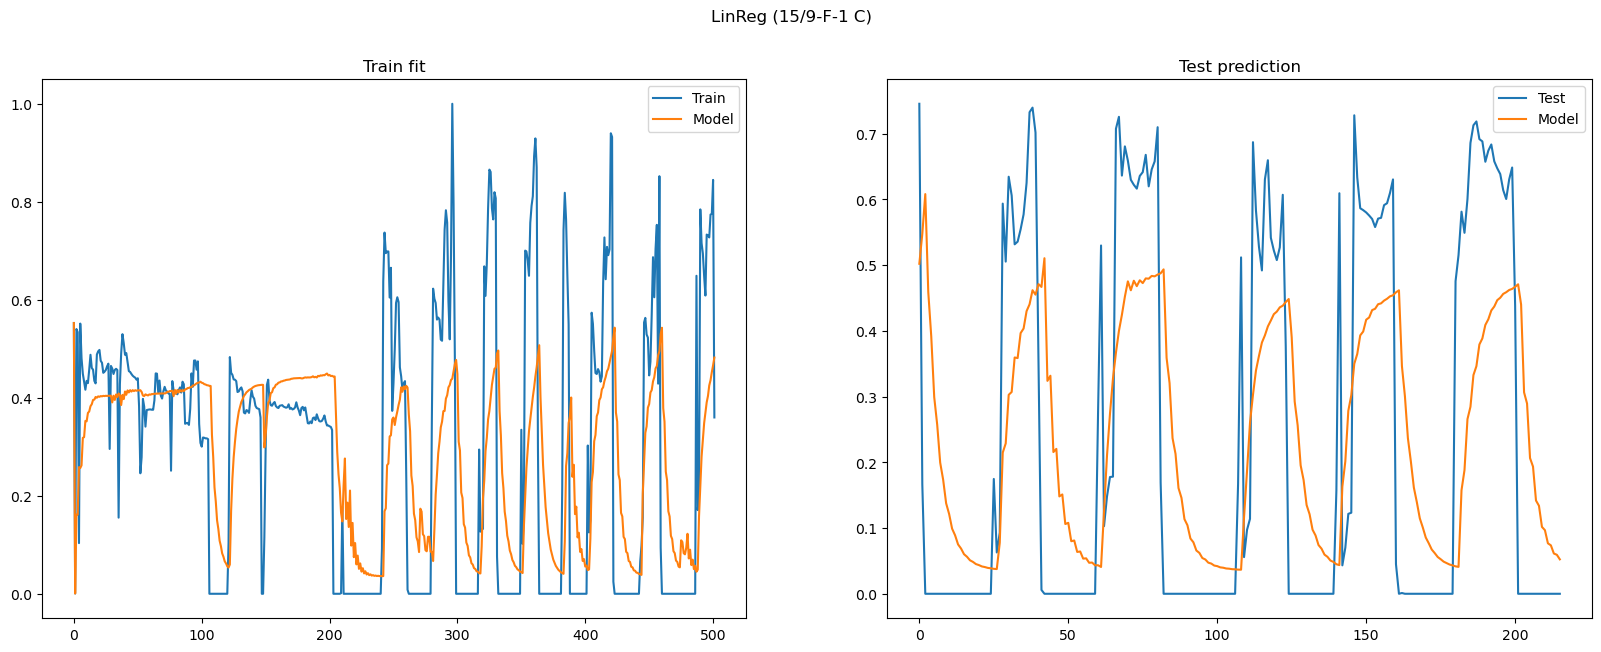

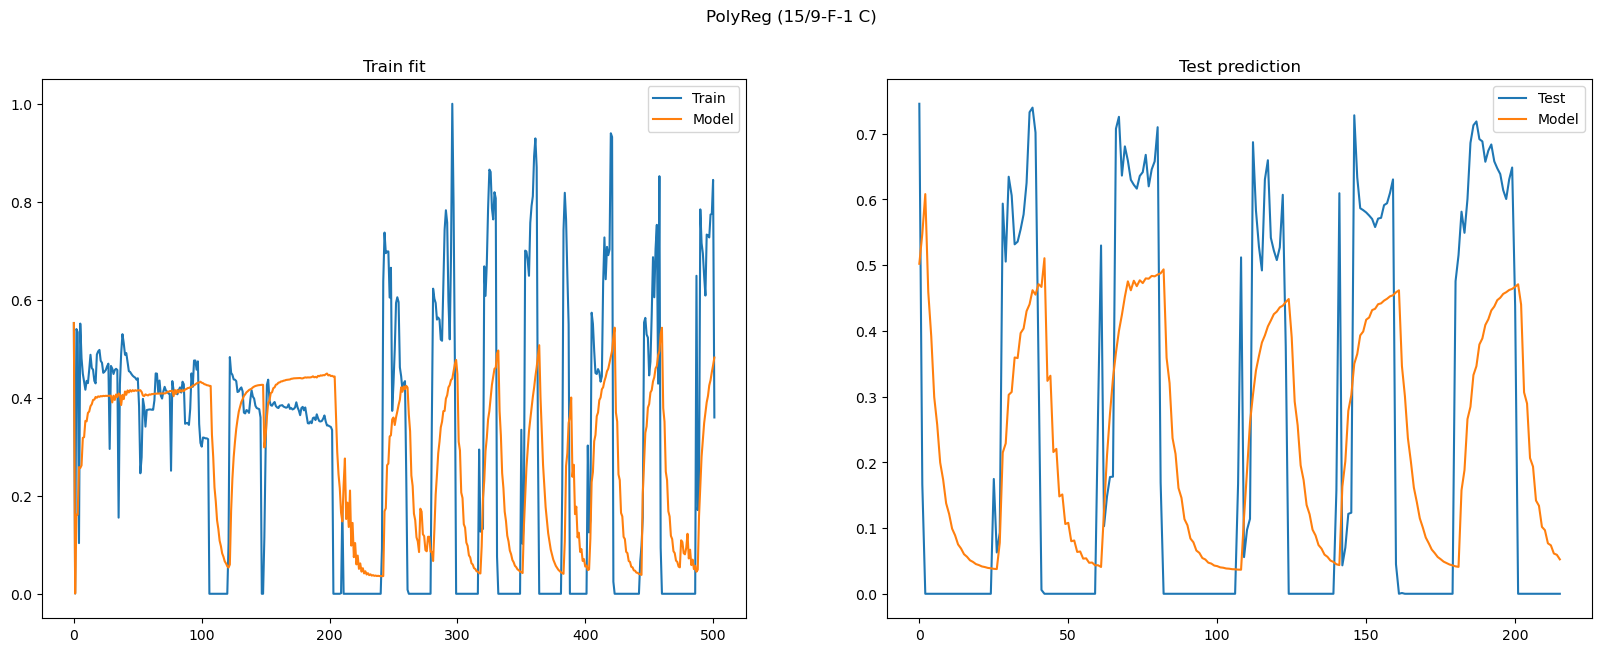

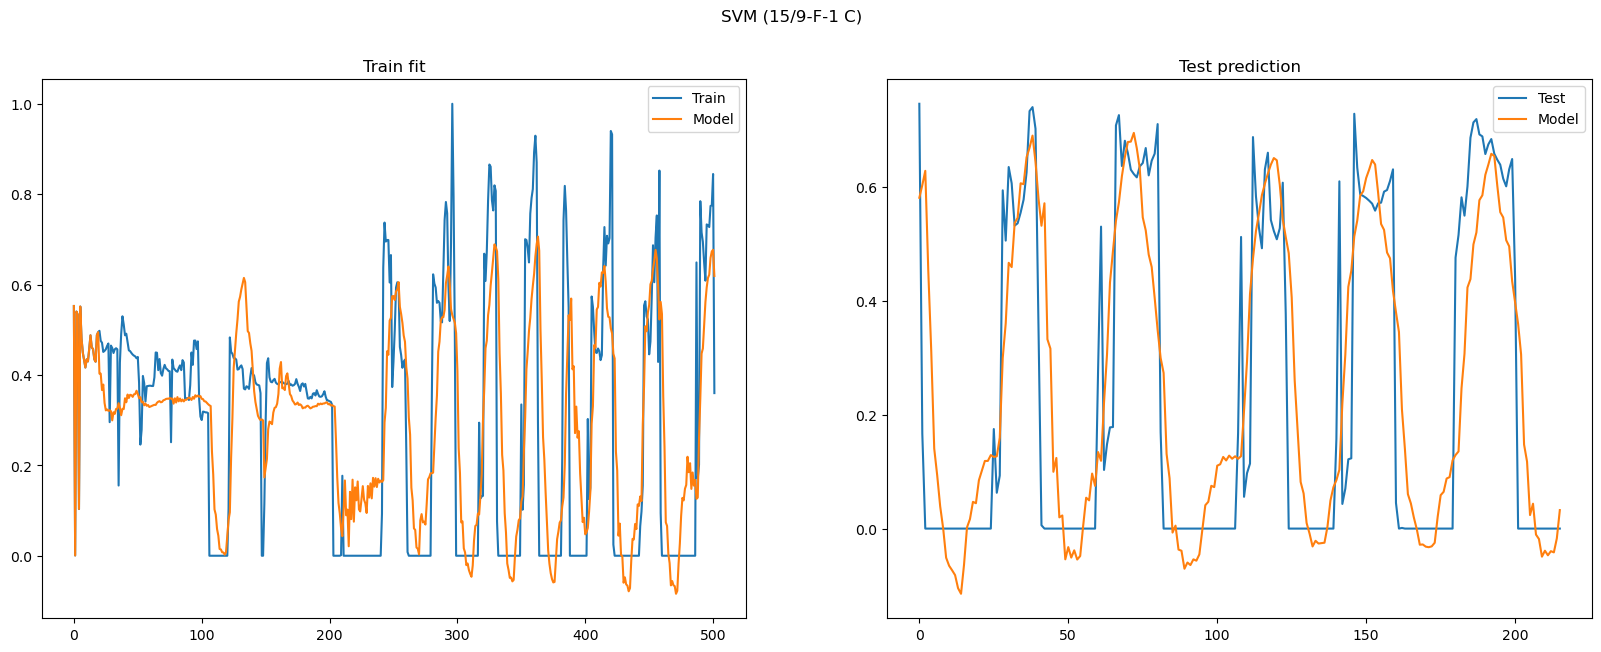

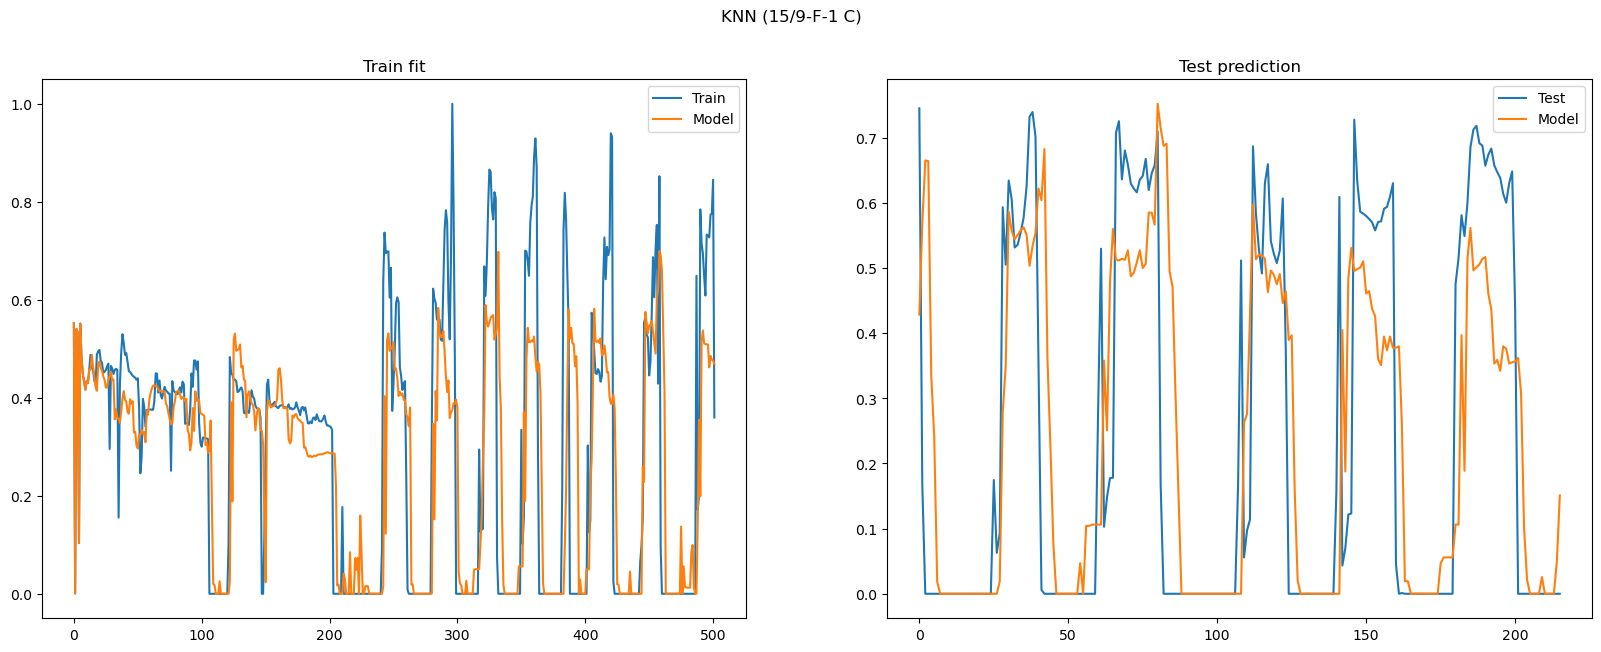

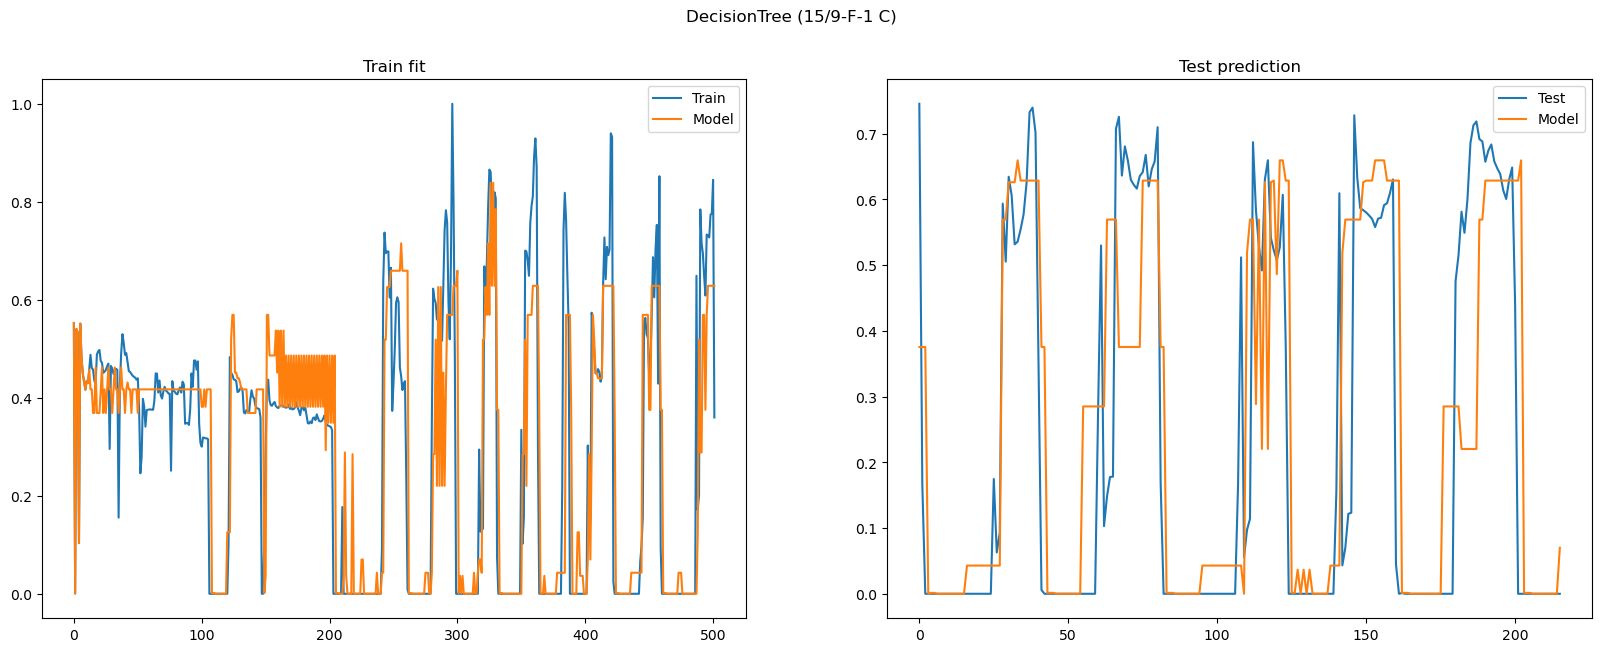

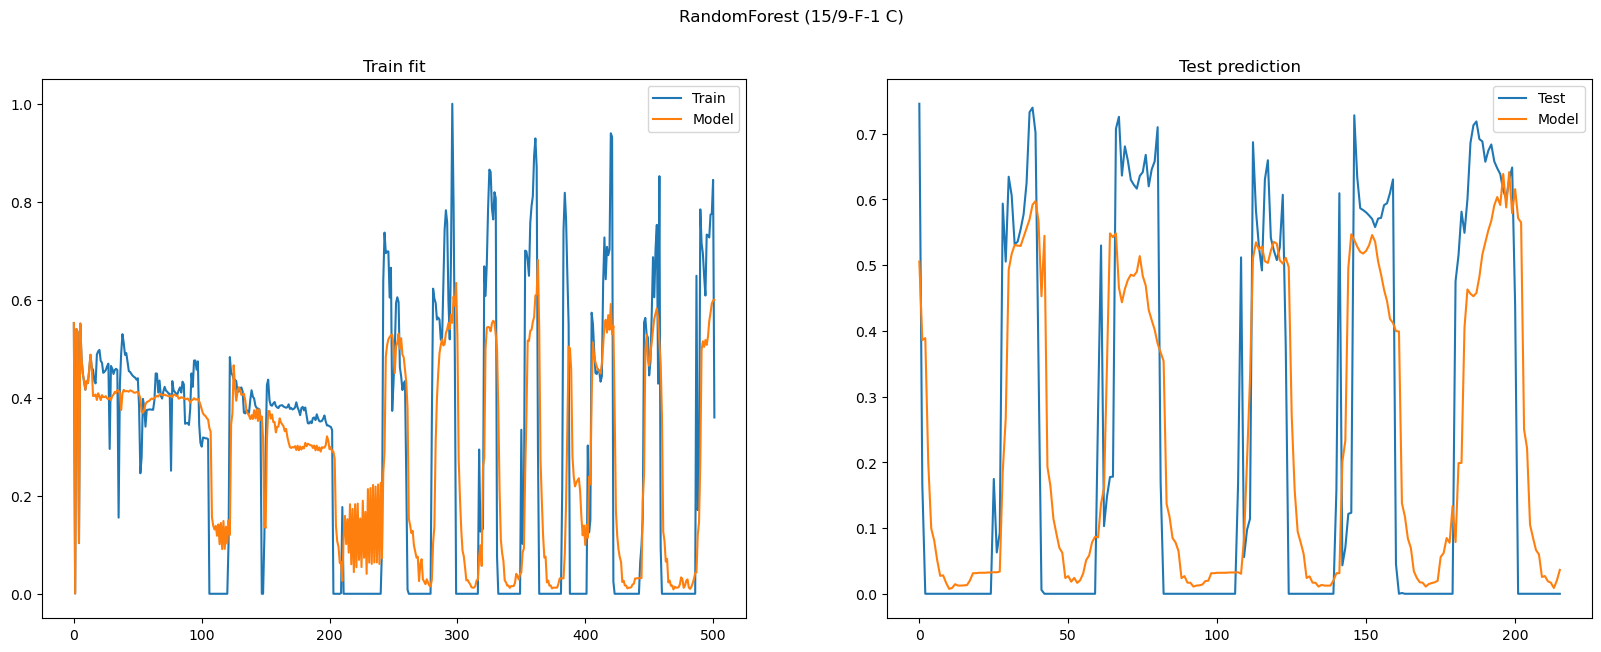

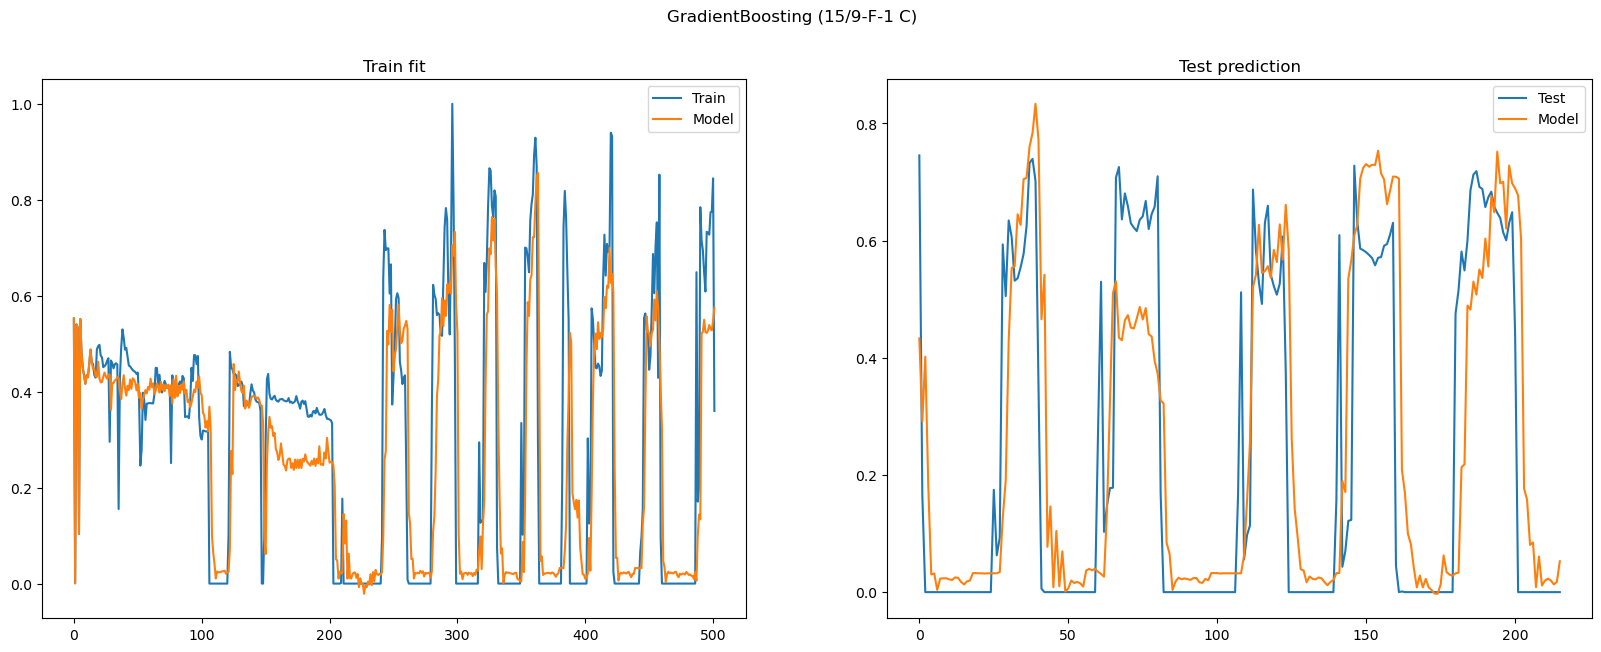

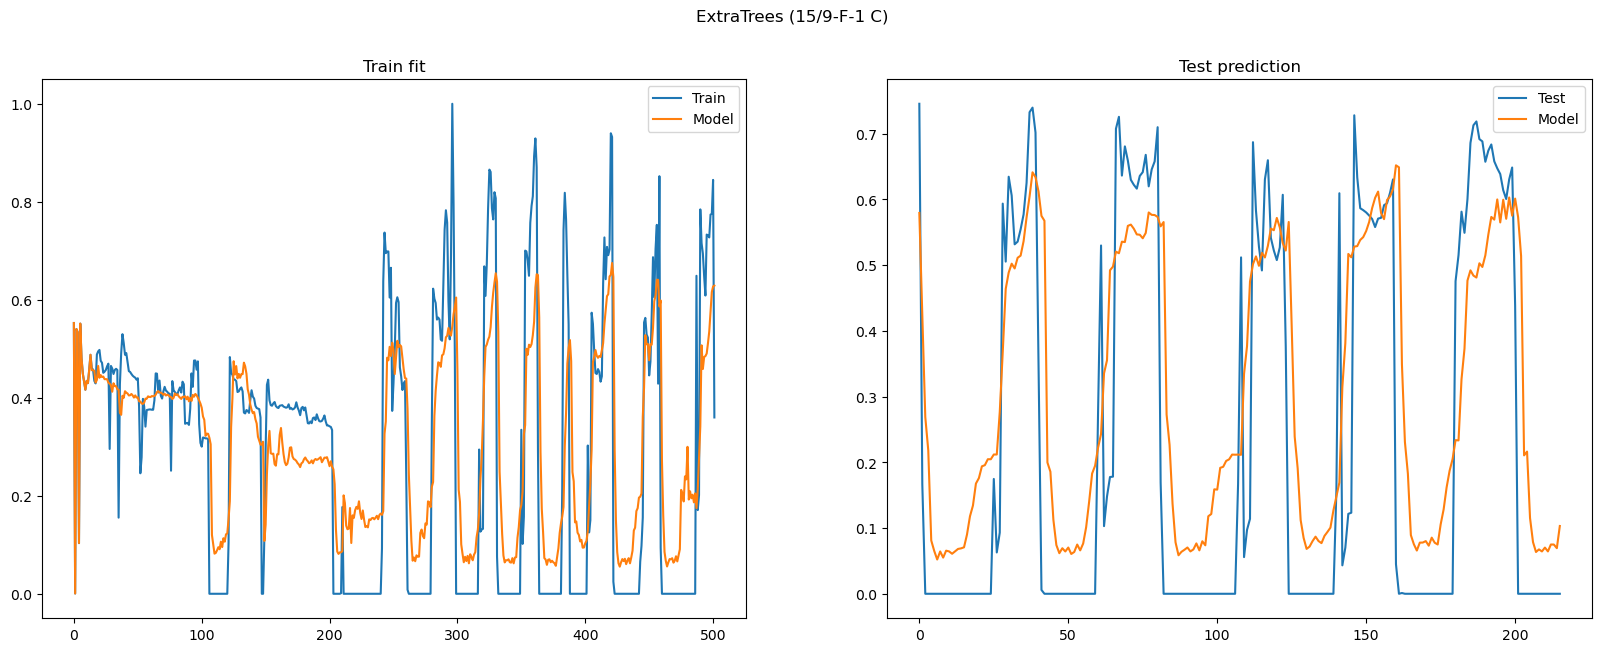

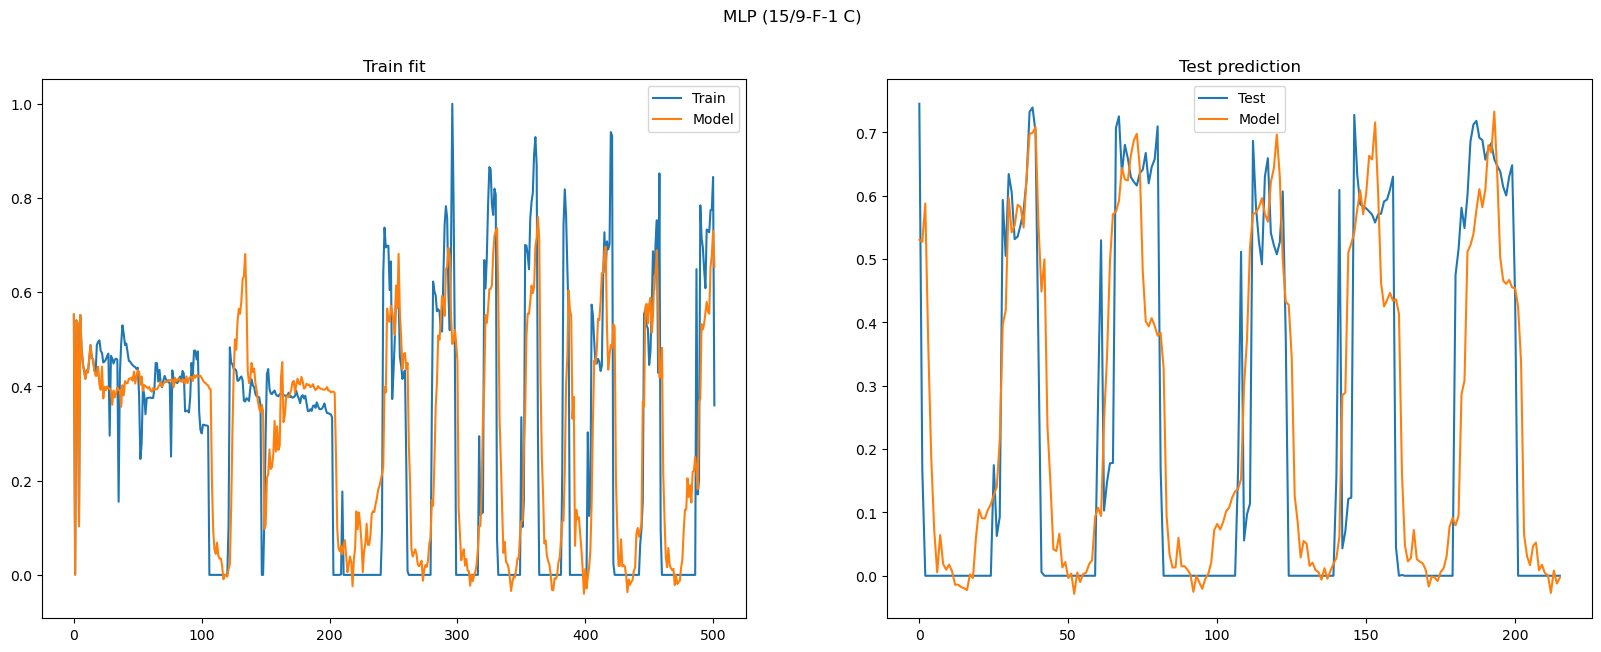

In [43]:

#fig, axs = plt.subplots(ncols=2, nrows=n_models, figsize=(25,n_models*7))
orders = range(2,21)
prefix = 'SISO.W1'
#Loop principal, iterando sobre as listas
for model in models:
    
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

    model_name, sidmodel = model

    print('Starting evaluation of model: {}'.format(model_name))
    
    t0 = datetime.now()

    best_r2_tr_fs = 1e6
    best_r2_te_fs = 1e6
    best_r2_tr_osa = 1e6
    best_r2_te_osa = 1e6
    best_order = 0
    best_model = sidmodel
    
    for order in orders:
        print(f'    Trying order: {order}')
        if hasattr(sidmodel, 'nX'): # is from our package
            sidmodel.nX = order
            sidmodel.ny = order
        else:
            sidmodel.xlag = [order]*X1_tr.shape[1]
            sidmodel.ylag = order
            sidmodel.elag = order
            regressors = regressor_code(X=X1_tr,
                                        xlag=[order]*X1_tr.shape[1],
                                        ylag=order,
                                        model_type="NARMAX",
                                        model_representation="neural_network",
                                        basis_function=sidmodel.basis_function
                                        )

            n_features = regressors.shape[0]
            
            #sidmodel.n_terms = n_features

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sidmodel.fit(X=X1_tr, y=y_tr)
        r2_tr_osa = r2_score(y_tr, sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1))
        r2_te_osa = r2_score(y_te, sidmodel.predict(X1_te, y=y_te, steps_ahead=1))
        try:
            r2_tr_fs = r2_score(y_tr, sidmodel.predict(X1_tr, y=y_tr))
            r2_te_fs = r2_score(y_te, sidmodel.predict(X1_te, y=y_te))
        except ValueError:
            r2_tr_fs = 1e290
            r2_te_fs = 1e290
        if np.abs(r2_tr_fs - 1) < np.abs(best_r2_tr_fs - 1):
            best_r2_tr_fs = r2_tr_fs
            best_r2_te_fs = r2_te_fs
            best_r2_tr_osa = r2_tr_osa
            best_r2_te_osa = r2_te_osa
            best_order = order
            best_model = sidmodel
        order_progression['MODEL'].append(model_name)
        order_progression['ORDER'].append(order)
        order_progression['R2 TRAIN OSA'].append(r2_tr_osa)
        order_progression['R2 TEST OSA'].append(r2_te_osa)
        order_progression['R2 TRAIN FS'].append(r2_tr_fs)
        order_progression['R2 TEST FS'].append(r2_te_fs)
        order_progression['MODEL OBJ'].append(sidmodel)
        print('        R2 score OSA (Train):', r2_tr_osa)
        print('        R2 score OSA (Test):', r2_te_osa)
        print('        R2 score FS (Train):', r2_tr_fs)
        print('        R2 score FS (Test):', r2_te_fs)
    
    if hasattr(sidmodel, 'nX'): # is from our package
        best_model.nX = best_order
        best_model.ny = best_order
    else:
        best_model.xlag = [best_order]*X1_tr.shape[1]
        best_model.ylag = best_order
        best_model.elag = best_order
    with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            best_model.fit(X=X1_tr, y=y_tr)
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Best Order:', best_order)
    print('    R2 score OSA (Train):', best_r2_tr_osa)
    print('    R2 score OSA (Test):', best_r2_te_osa)
    print('    R2 score FS (Train):', best_r2_tr_fs)
    print('    R2 score FS (Test):', best_r2_te_fs)

    hist = ax[0].plot(y_tr, label='Train')
    hist = ax[0].plot(best_model.predict(X1_tr, y=y_tr), label='Model') 
    ax[0].set_title(f'Train fit')
    ax[0].legend()
    hist = ax[1].plot(y_te[n_train:,:], label='Test')
    hist = ax[1].plot(best_model.predict(X1_te, y=y_te)[n_train:,:], label='Model')
    ax[1].set_title(f'Test prediction')
    ax[1].legend()
    fig.suptitle(f'{model_name} ({case})')
    fig.savefig(os.path.join(os.getcwd(),'outputs',f'{prefix}_{model_name}.png'))
    print()
    
    results['MODEL'].append(model_name) 
    results['ORDER'].append(best_order)
    results['R2 TRAIN OSA'].append(best_r2_tr_osa)
    results['R2 TEST OSA'].append(best_r2_te_osa)
    results['R2 TRAIN FS'].append(best_r2_tr_fs)
    results['R2 TEST FS'].append(best_r2_te_fs) 
    results['MODEL OBJ'].append(sidmodel)
    try:
        results['PARS'].append(sidmodel.estimator.best_params_)
    except Exception:
        results['PARS'].append(sidmodel.final_model)

In [44]:
pd.DataFrame(results)

,MODEL,ORDER,R2 TRAIN OSA,R2 TEST OSA,R2 TRAIN FS,R2 TEST FS,MODEL OBJ,PARS
0,ARMAX,20,0.762585,0.760640,-1.000125,-0.863902,<sysidentpy.model_structure_selection.forward_...,[[1001]]
1,NARMAX,20,0.762585,0.760640,-1.000125,-0.863902,<sysidentpy.model_structure_selection.forward_...,"[[1001, 0]]"
2,LinReg,2,0.773766,0.776327,0.371276,0.396050,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,{'positive': True}
3,PolyReg,2,0.773766,0.776327,0.371276,0.396050,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,{'Reg__positive': True}
4,SVM,20,0.813152,0.799860,0.572774,0.607321,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'C': 5.275248070624684, 'degree': 3, 'gamma':..."
5,KNN,12,0.998534,0.901331,0.541543,0.525616,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'n_neighbors': 6, 'weights': 'distance'}"
6,DecisionTree,13,0.876747,0.818843,0.651664,0.614181,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 8, 'max_features': 0.22701940305..."
7,RandomForest,15,0.916821,0.874120,0.631925,0.642703,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 7, 'max_features': 0.37874282408..."
8,GradientBoosting,15,0.963960,0.895868,0.649850,0.631856,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'criterion': 'friedman_mse', 'learning_rate':..."
9,ExtraTrees,14,0.949342,0.887701,0.635594,0.620710,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'criterion': 'squared_error', 'max_depth': 14..."


In [45]:
order_progression = pd.DataFrame(order_progression)
order_progression

,MODEL,ORDER,R2 TRAIN OSA,R2 TEST OSA,R2 TRAIN FS,R2 TEST FS,MODEL OBJ
0,ARMAX,2,0.743103,0.747953,-1.194461,-0.990453,<sysidentpy.model_structure_selection.forward_...
1,ARMAX,3,0.751437,0.753381,-1.098927,-0.928242,<sysidentpy.model_structure_selection.forward_...
2,ARMAX,4,0.751499,0.753421,-1.094368,-0.925272,<sysidentpy.model_structure_selection.forward_...
3,ARMAX,5,0.755586,0.756083,-1.154136,-0.964193,<sysidentpy.model_structure_selection.forward_...
4,ARMAX,6,0.761591,0.759993,-1.076512,-0.913645,<sysidentpy.model_structure_selection.forward_...
...,...,...,...,...,...,...,...
204,MLP,16,0.872931,0.836008,0.487073,0.547690,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
205,MLP,17,0.821653,0.796313,0.619647,0.643090,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
206,MLP,18,0.805291,0.796889,0.607951,0.630841,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
207,MLP,19,0.837391,0.813864,0.610652,0.632690,SYSIDRegressor(estimator=RandomizedSearchCV(cv...


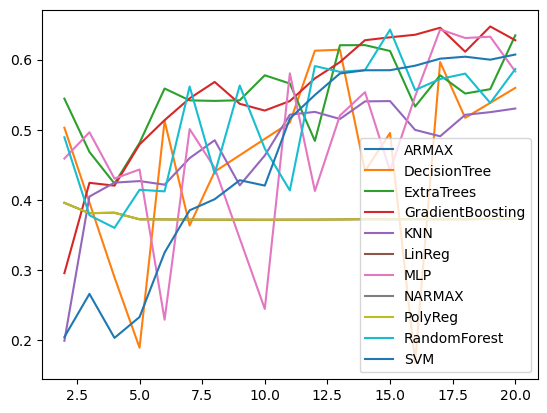

In [46]:
fig, ax = plt.subplots()
for model in np.unique(order_progression.MODEL):
    #if model == 'DT': continue
    data_filt = order_progression[order_progression.MODEL == model]
    data_filt = data_filt[data_filt['R2 TEST FS'] >= 0]
    ax.plot(data_filt.ORDER, data_filt['R2 TEST FS'], label=model)
ax.legend()

In [47]:

binary = os.path.join(os.getcwd(), 'outputs', f'{prefix}_ml.pkl')
print(binary)

with open(binary, 'wb') as bin_file:
    pickle.dump((X1_tr, y_tr, X1_te, y_te, results, order_progression), bin_file)


/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_Trabalho/Volve-Dataset/outputs/SISO.W1_ml.pkl


In [48]:
print(results['PARS'][-1])

{'activation': 'relu', 'alpha': 0.0012410389662492736, 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (80, 80, 60, 20), 'max_iter': 10000, 'solver': 'adam', 'tol': 0.001409041232546495}
